1. Region Proposal network (RPN)
2. RPN loss functions
3. Region of Interest Pooling (ROI)
4. ROI loss functions

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt

import numpy as np

import itertools
import cv2
from PIL import Image

## Feautre Extraction

(512, 512, 3)


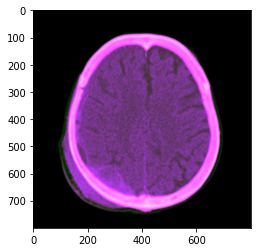

In [2]:
img0 = cv2.imread('../data/brain/sample.png')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)

img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_LINEAR)
plt.imshow(img)
plt.show()

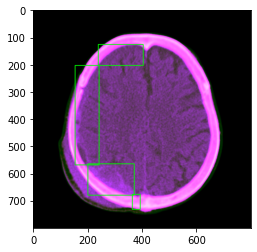

In [3]:
Wratio = 800 / img0.shape[1]
Hratio = 800 / img0.shape[0]
ratioList = [Wratio, Hratio, Wratio, Hratio]

# [x1, y1, x2, y2]
bbox0 = np.array([[233., 433., 252., 468.],
                  [129., 361., 238., 435.],
                  [ 99., 130., 155., 364.],
                  [153.,  81., 259., 130.]], dtype = np.float32)

bbox = np.array(bbox0 * ratioList)

labels = np.array([2, 1, 1, 1]) # 1: hemorrhage 2: fracture

# display bounding box and labels
img_clone = img.copy()

for i in bbox:
    x1, y1, x2, y2 = map(int, i)
    cv2.rectangle(img_clone,(x1,y1),(x2, y2),(0,255,0),2)

plt.imshow(img_clone)
plt.show()

In [4]:
model = torchvision.models.vgg16(pretrained=True)
imgTensor = torch.from_numpy(img).to(torch.float32)
imgTensor = imgTensor.permute(2,0,1).unsqueeze(0)

fe = list(model.features)

# req_features = fe[:30]
req_features = []
k = imgTensor.clone()
for i in fe:
    k = i(k)
    if k.size()[2] < 512 // 16:
        break
    req_features.append(i)
    out_channels = k.size()[1]

print(len(req_features))
print(out_channels)

30
512


In [5]:
faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [6]:
output_map = faster_rcnn_feature_extractor(imgTensor)
print(output_map.size())

torch.Size([1, 512, 50, 50])


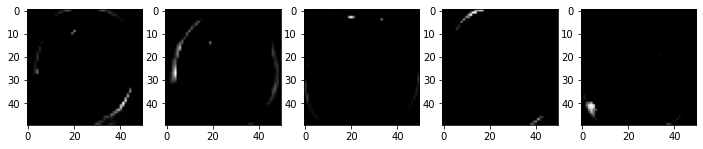

In [7]:
imgArray = output_map.data.numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

## Anchor boxes

1) Generate anchors

2500
center example: 
 [[ 8.  8.]
 [24.  8.]
 [40.  8.]] ....



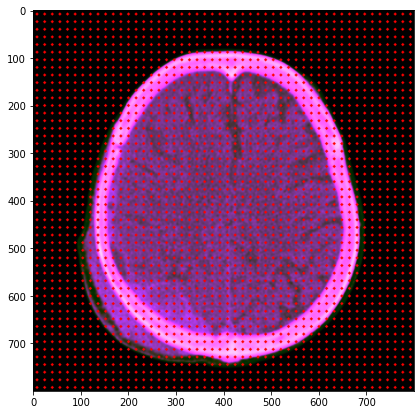

In [8]:
feature_size = (800 // 16)  # 피처맵은 50 x 50
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)  # stride = 16
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)

ctr = np.zeros((len(ctr_x) * len(ctr_y), 2))
for idx, (x,y) in enumerate(itertools.product(ctr_x, ctr_y)):
    ctr[idx, 1] = x - 8
    ctr[idx, 0] = y - 8

print(len(ctr))
print(f'center example: \n {ctr[:3]} ....\n')

img_clone2 = np.copy(img)
ctr_int = ctr.astype(np.int32)

plt.figure(figsize=(7,7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]), radius=1, color = (255,0,0), thickness=3)
plt.imshow(img_clone2)
plt.show()

2) Geneate anchor_boxes

In [9]:
ratios = [0.2, 0.5, 1, 2, 4]
scales = [4, 8, 16, 32]
anchor_size = len(ratios) * len(scales)

sub_sample = 16
anchor_boxes = np.zeros((feature_size * feature_size * anchor_size, 4))

idx = 0
for c_y, c_x in ctr:
    for ratio, scale in itertools.product(ratios, scales):
        h = sub_sample * scale * np.sqrt(ratio)
        w = sub_sample * scale * np.sqrt(1. / ratio)
        anchor_boxes[idx, 0] = c_y - h / 2 
        anchor_boxes[idx, 1] = c_x - w / 2
        anchor_boxes[idx, 2] = c_y + h / 2
        anchor_boxes[idx, 3] = c_x + w / 2 
        idx += 1
        
print(f'anchor shape:{anchor_boxes.shape}')
print(anchor_boxes[:10,:])

anchor shape:(50000, 4)
[[  -6.31083506  -63.55417528   22.31083506   79.55417528]
 [ -20.62167011 -135.10835056   36.62167011  151.10835056]
 [ -49.24334022 -278.21670112   65.24334022  294.21670112]
 [-106.48668045 -564.43340224  122.48668045  580.43340224]
 [ -14.627417    -37.254834     30.627417     53.254834  ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -24.          -24.           40.           40.        ]
 [ -56.          -56.           72.           72.        ]]


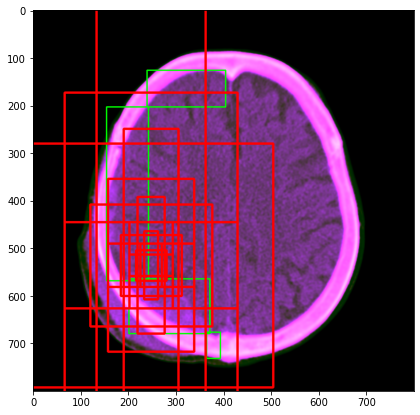

In [10]:
# display the anchor boxes of one anchor and the ground truth boxes

# draw random anchor boxes
for i in range(33300, 33315):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)
plt.figure(figsize=(7,7))
plt.imshow(img_clone)
plt.show()

## Target Anchors

1) anchor boxes inside the image 

In [11]:
inside_index = np.where((anchor_boxes[:,0] >=0) &
                        (anchor_boxes[:,1] >=0) &
                        (anchor_boxes[:,2] <=800) &
                        (anchor_boxes[:,3] <=800))[0]

print(f'valid anchor counts: {inside_index.shape}')


valid_anchor_boxes = anchor_boxes[inside_index]

print(f'valid anchor shape:{valid_anchor_boxes.shape}')

valid anchor counts: (23692,)
valid anchor shape:(23692, 4)


2) Calculate IoUs

In [12]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [13]:
ious = np.zeros((len(valid_anchor_boxes), 4), dtype=np.float32)
print(f'bbox: \n {bbox}')

for idx, anchor in enumerate(valid_anchor_boxes):
    iou1 = IoU(bbox[0], anchor)
    iou2 = IoU(bbox[1], anchor)
    iou3 = IoU(bbox[2], anchor)
    iou4 = IoU(bbox[3], anchor)
    ious[idx] = [iou1, iou2, iou3, iou4]
    
print(f'ious shape: {ious.shape}')

bbox: 
 [[364.0625 676.5625 393.75   731.25  ]
 [201.5625 564.0625 371.875  679.6875]
 [154.6875 203.125  242.1875 568.75  ]
 [239.0625 126.5625 404.6875 203.125 ]]
ious shape: (23692, 4)


3) Sample positive/negative anchor boxes

In [14]:
gt_argmax_ious = ious.argmax(axis = 0) # 어떤 anchor 박스가 gt_box와(bbox) 가장 높은 iou를 가지는가
print(gt_argmax_ious) 

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])] # max iou 값
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0] # 가장 높은 iou 값을 같는 anchor box의 위치
print(gt_argmax_ious)


[22231 19732 10040  3265]
[0.40373382 0.73761046 0.51557356 0.77590305]
[ 3265 10040 10054 10654 10669 11296 11311 11938 11953 12580 12595 19732
 20274 22231 22631]


In [15]:
argmax_ious = ious.argmax(axis=1) # 두개의 bbox중 iou max값을 갖는 인덱스 위치(argmax_ious)

print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(inside_index)), argmax_ious] # 두개의 bbox중 max iou의 값들의 집합
print(max_ious)

(23692,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


- anchor 박스로 iou 계산 시 너무 많은 negative sample이 나오기 때문에 pos 와 neg 균형을 1:1로 맞추어 주는 작업이 필요  
  한장의 이미지 당 random 하게 256개의 anchor를 1대1로 맞춰 학습을 진행한다.  
  만약 pos가 128보다 적으면 neg를 padding한다.

In [16]:
label = np.empty((len(inside_index),), dtype=np.int32)
label.fill(-1)
print(f'anchor box labels: {label.shape}')

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious < neg_iou_threshold] = 0
label[max_ious > pos_iou_threshold] = 1

anchor box labels: (23692,)


In [17]:
n_sample = 256  
pos_ratio = 0.5

# positive samples
n_pos = pos_ratio * n_sample
pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace = False)
    label[disable_index] = -1

# negative samples
n_neg = np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1


<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FHaclG%2FbtqBdUkizUl%2FOzPRkcX2FPJPFmN8BKlzl1%2Fimg.png" width="600" height="400">

- 출처 https://ganghee-lee.tistory.com/37

In [18]:
# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width


eps = np.finfo(height.dtype).eps #dtype이 가질수 있는 최소값
height = np.maximum(height, eps) # 가능 최소값보다 큰것
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)

(23692, 4)
(23692, 4)


In [19]:
# Final labels:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[inside_index] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

# Final locations
anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[inside_index, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10])

(50000,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(50000, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


- anchor_locations [N, 4] — [22500, 4]
- anchor_labels [N,] — [22500]

----
## Resion Proposal Network

<img src="https://miro.medium.com/max/700/1*rQ99lLIs7xTAjTaKHHNatA.png" width="700" height="600">

- A box regrression layer
- A box classification layer

1) Define RPN

In [20]:
import torch.nn as nn 

mid_channels = 512
in_channels = 512
n_anchor = 20        # Number of anchors at each location in the feature map

# conv1 sliding layer
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# reg_layer
reg_layer = nn.Conv2d(mid_channels, n_anchor*4, 1, 1, 0)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# cls_layer
cls_layer = nn.Conv2d(mid_channels, n_anchor*3, 1, 1, 0)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()



tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

2) Classifiaction and Bounding box regression

pred_cls_scores와 pred_anchor_locs 는 RPN network의 output 이며 가중치를 업데이트하기 위한 loss <br>
pred_cls_scores와 objectness_score 는 proposal layer에 input으로 사용, 추후 RoI 네트워크에 의해 사용되는 제안 집합 생성.

In [23]:
x= conv1(output_map)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 80, 50, 50]) torch.Size([1, 60, 50, 50])


In [24]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3 ,1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 20, 3)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 3)
print(pred_cls_scores.shape)

torch.Size([1, 50000, 4])
torch.Size([1, 50, 50, 60])
torch.Size([1, 50000])
torch.Size([1, 50000, 3])


In [25]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([50000, 4]) torch.Size([50000, 3]) torch.Size([50000, 4]) torch.Size([50000])


3) Multi-task loss

In [26]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long(), ignore_index= -1)
print(rpn_cls_loss)

tensor(1.8184, grad_fn=<NllLossBackward>)


In [27]:
# only positive samples
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([50000, 4])
torch.Size([18, 4]) torch.Size([18, 4])
tensor(69.6271, dtype=torch.float64, grad_fn=<SumBackward0>)


In [28]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(40.5002, dtype=torch.float64, grad_fn=<AddBackward0>)


## Proposal layer

1) Transform anchor boxes

In [29]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000    # after nms, training using 2000 RPN proposals

n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

# the labelled 50000 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(50000,)


In [30]:
# The 50000 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)
pred_anchor_locs_numpy = pred_anchor_locs[0].data.numpy()
objectness_score_numpy = objectness_score[0].data.numpy()


dy = pred_anchor_locs_numpy[:, 1]
dx = pred_anchor_locs_numpy[:, 0]
dh = pred_anchor_locs_numpy[:, 3]
dw = pred_anchor_locs_numpy[:, 2]

print(dy.shape)

(50000,)


In [31]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, ] + anc_ctr_y[:, ]
ctr_x = dx * anc_width[:, ] + anc_ctr_x[:, ]
h = np.exp(dh) * anc_height[:, ]
w = np.exp(dw) * anc_width[:, ]
print(w.shape)

# region of interest 
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype = np.float32)
roi[:, 0] = ctr_y - 0.5 * h
roi[:, 1] = ctr_x - 0.5 * w
roi[:, 2] = ctr_y + 0.5 * h
roi[:, 3] = ctr_x + 0.5 * w

print(roi.shape)

(50000,)
(50000, 4)


2) Clip the predicted boxes to the image

In [32]:
img_size = (800, 800)
roi = roi.clip(0, img_size[0]) # 직사각형인 경우 달라질 수 있음
print(roi.shape, np.max(roi), np.min(roi))

(50000, 4) 800.0 0.0


In [33]:
# remove predicted boxes with either height or width < threshold
hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]

roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(36197,) (36197, 4) (36197,)


3) Select top 12000 anchor boxes by objectness score

In [34]:
order = score.ravel().argsort()[::-1]
print(order.shape)

order = order[:n_train_pre_nms]
roi_1 = roi[order, :]
print(order.shape, roi_1.shape)  # 12000개의 anchor_box

(36197,)
(12000,) (12000, 4)


4) Non maximum suppression(select 2000 bounding boexs)

In [35]:
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

# non maximum suppression
order = score.argsort()[::-1]   # order: indexes of descending score order
keep = []

while (order.size > 0):
    i = order[0]
    keep.append(i)
    
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])

    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly

roi_2 = roi[keep]
print(len(keep), roi_2.shape)

2000 (2000, 4)


## Proposal Target layer 

1) Calculate IoUs 

In [36]:
n_sample = 128   #num_samples from roi
pos_ratio = 0.25 
pos_iou_threshold = 0.3   # positive label
neg_iou_threshold = 0.3   # background 0 
neg_iou_thresh_lo = 0.0

In [37]:
ious = np.zeros((len(roi_2), bbox.shape[0]), dtype=np.float32)

for idx, roi in enumerate(roi_2):
    iou1 = IoU(bbox[0], roi)
    iou2 = IoU(bbox[1], roi)
    iou3 = IoU(bbox[2], roi)
    iou4 = IoU(bbox[3], roi)
    ious[idx] = [iou1, iou2, iou3, iou4]
    
print(f'ious shape: {ious.shape}')

ious shape: (2000, 4)


In [38]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[0 3 0 ... 0 2 1]
[0.         0.01201011 0.         ... 0.         0.03609772 0.01527586]
[2 1 2 ... 2 1 1]


2) Select positive samples

In [39]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_threshold)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
    pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)

    
print(pos_roi_per_this_image)
print(pos_index)

32
[ 250  958 1261  440  236 1142  471  501  558 1819 1925 1878 1407 1475
 1615 1891  676 1879 1240 1380  507  651 1788  903 1126 1346 1626  802
 1022 1123  636 1280]


3) Select negative samples

In [40]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_threshold) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

96
[1714 1325 1787  815 1488   77 1835  821 1370  673 1038  502  992 1647
  415  439  107 1796 1418  405  928  574 1087 1749   35 1477 1476  404
 1981 1203  926 1204 1278  911  319  643 1002 1441   43 1985 1422  124
 1648 1268  998 1792 1777  514  618  920 1578 1433 1223  100   23 1021
 1548  823  469 1214 1253  747  594 1929   64  798   33 1057 1435 1935
 1785  635 1559 1226 1740  205  880   71  209 1216 1713 1071  534  929
 1426  561 1147 1933 1140 1732  583 1099  744 1940 1020 1312]


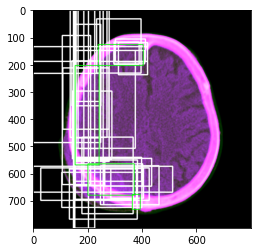

In [41]:
# display RoI samples with positive

img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
    x1, y1, x2, y2 = roi_2[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                  thickness=3)

    
for i in bbox:
    x1, y1, x2, y2 = map(int, i)
    cv2.rectangle(img_clone,(x1,y1),(x2, y2),(0,255,0),2)

plt.imshow(img_clone)
plt.show()

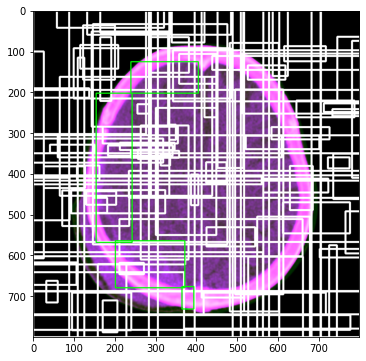

In [42]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
    x1, y1, x2, y2 = roi_2[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                  thickness=3)

    
for i in bbox:
    x1, y1, x2, y2 = map(int, i)
    cv2.rectangle(img_clone,(x1,y1),(x2, y2),(0,255,0),2)

    
plt.imshow(img_clone)
plt.show()

5) Gather positive/negative samples

In [59]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi_2[keep_index]
print(sample_roi.shape)

(128, 4)


In [60]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to anchor boxes
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height

(128, 4)


In [61]:
# transform anchor boxes
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


## Roi pooling

1) Concatenate labels with bbox coordinates

In [62]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [63]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


2) Roi pooling

In [64]:
size = (7,7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0)  # sub_sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
    
output = torch.cat(output, 0)

print(output.size())



torch.Size([128, 512, 7, 7])


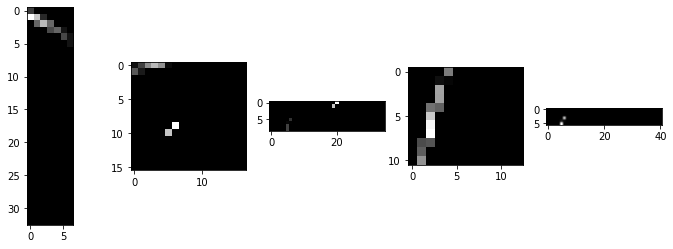

In [65]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [66]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


# Fast R-CNN

1) Classifier and Bounding box regressor

In [67]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)])

cls_loc = nn.Linear(4096, 3 * 4) # 2 class, 1 background, 4 coordinates 
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 3)

In [68]:
k = roi_head_classifier(k)
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

In [69]:
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 12])
torch.Size([128, 3])
(128, 4)
(128,)


In [72]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

2) Classification loss

In [74]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

# Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score, gt_roi_label, ignore_index=-1) # -1인 value는 gradient에 영향 x

torch.Size([128, 4]) torch.Size([128])


3) Regression loss

In [128]:
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 3, 4])
torch.Size([128, 4])


In [129]:
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [141]:
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x= torch.abs(mask_loc_targets - mask_loc_preds)
roi_loc_loss = ((x < 1).float()*0.5*x**2) + ((x>=1).float()*(x - 0.5))
print(roi_loc_loss.sum())

torch.Size([32, 4]) torch.Size([32, 4])
tensor(214.8658, dtype=torch.float64, grad_fn=<SumBackward0>)


4) Multi-task loss

In [147]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss.sum())
print(roi_loss)

total_loss = rpn_loss + roi_loss
print(total_loss)

tensor(2150.2095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2190.7097, dtype=torch.float64, grad_fn=<AddBackward0>)
